# Group assignment -- AldeBlock Pharmaceuticals

Stefanie Sturm, Louke Vaessen, Troy van Westen, Luisa Koppers, Michelle van Velthoven, Roos Ezendam en Fleur de Haar

### Installing recruired packages 

In [1]:
# install kneed
!pip install --upgrade kneed

In [2]:
#insert all packages needed
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from kneed import KneeLocator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


### Import the data 

In [3]:
#import the smiles list
file_name = r"tested_molecules-1.csv"
with open(file_name, "r") as ins:
    smiles = []
    for line in ins:
        smiles.append(line.split('\n')[0])
print('# of SMILES:', len(smiles))


# of SMILES: 1001


In [4]:
#split the csv file into multiple columns
#read the dataframe
df_molecules = pd.read_csv(file_name)

# #split the csv file into multiple columns
# #read the dataframe
df_molecules = pd.read_csv(file_name)

print(df_molecules)

# #split the dataframe
#new_columns = df_molecules['SMILES,"ALDH1_inhibition"'].str.split(';', expand=True)
#df_molecules = pd.concat([df_molecules, new_columns], axis=1)

# #drop the original column
#df_molecules = df_molecules.drop('SMILES;ALDH1_inhibition', axis=1)

# #rename the column names 
#df_molecules = df_molecules.rename(columns={0:'SMILES',1:'ALDH1_inhibition'})

#df_molecules


                                                SMILES  ALDH1_inhibition
0    COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...                 1
1               O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1                 1
2    Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...                 1
3                    CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1                 1
4    CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21                 1
..                                                 ...               ...
995             COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1                 0
996                       CCNc1oc(COc2cccc(C)c2)nc1C#N                 0
997                          NC(=O)Cn1cnc(-c2ccccc2)c1                 0
998  Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...                 0
999          O=C(Cn1nnc2c(cnn2-c2ccccc2)c1=O)NCc1cccs1                 0

[1000 rows x 2 columns]


## Data analysis and preperation

In [5]:
#since the list is very large, to try stuff out, we look at the first 4 smiles
only_smiles_list = df_molecules['SMILES']

smiles_tryout = only_smiles_list
smiles_tryout;


In [6]:
#draw the four mole images
mols = [Chem.MolFromSmiles(smi) for smi in smiles_tryout]
#Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(200, 200))

In [7]:
#calculate descriptor list

desc_list = [n[0] for n in Descriptors._descList]
#print(len(desc_list))
#print(desc_list)

In [8]:
#calculate molecular descriptors and make them floats
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)

rdkit_desc_data = [calc.CalcDescriptors(m) for m in mols]

rdkit_desc = []
for element in rdkit_desc_data:   
    tuple_floats = tuple(float(x) for x in element)
    rdkit_desc.append(tuple_floats)
    
#print(rdkit_desc_data[0])
#print(rdkit_desc[0])

In [9]:
#add columns to dataframe

for col in range(len(desc_list)):
    column = []
    for row in range(len(rdkit_desc)):
        #the row iteration is for the molecule and the col iteration for the descriptor, this makes a list which will be
        #added to the dataframe
        descriptor = rdkit_desc[row][col]
        column.append(descriptor)
    df_molecules[desc_list[col]] = column
    
#Drop the irrelevant columns that only say something about one molecule
df_molecules = df_molecules.drop(columns=['fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_molecules

C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\1826652631.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_molecules[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\1826652631.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_molecules[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\1826652631.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,...,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,178.0,0.0,0.249868,-0.496477,0.496477,0.249868,1.088235,1.794118,2.500000,16.465857,10.012387,2.277377,-2.329164,2.213373,-2.524368,5.869762,-0.128181,3.345650,1.374647,1110.519072,23.915638,19.347200,19.347200,16.546045,11.329861,11.329861,8.265229,8.265229,5.888540,5.888540,4.187622,4.187622,-3.95,6.958111e+07,23.216344,10.778358,5.506759,197.833708,20.270350,11.791353,...,64.304606,16.009896,0.000000,25.328832,54.597304,0.000000,5.687386,0.0,114.27,6.041841,9.589074,0.0,17.856200,31.208186,24.092481,6.923737,11.791600,54.597304,31.058939,4.736863,7.122812,0.000000,26.972964,18.075462,1.758225,0.920982,16.565369,1.837103,2.822263,1.591488,0.375000,34.0,2.0,10.0,0.0,1.0,1.0,2.0,1.0,3.0,8.0,2.0,10.0,8.0,0.0,1.0,1.0,4.0,1.50330,126.8344
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,136.0,0.0,0.230353,-0.467476,0.467476,0.230353,1.111111,2.000000,2.814815,32.166556,10.202245,2.140429,-2.083839,2.235385,-2.240774,7.993662,-0.118316,3.338816,1.485090,1028.775024,18.476481,14.538559,15.355056,13.292826,8.564791,9.550390,5.957024,6.899523,4.024513,5.000911,2.736403,3.568412,-3.06,3.137659e+06,17.358644,8.092317,4.199706,160.174276,9.733940,11.276948,...,26.195090,17.884050,0.000000,11.323699,76.630898,0.000000,11.163878,0.0,72.95,0.000000,4.794537,0.0,11.660033,13.089513,27.644013,11.761885,18.526374,36.398202,31.984579,4.417151,7.276561,1.406535,21.295170,3.630481,2.804024,0.940073,17.587352,3.352383,1.040755,0.000000,0.150000,27.0,1.0,6.0,0.0,0.0,0.0,1.0,3.0,4.0,6.0,1.0,7.0,7.0,0.0,0.0,0.0,4.0,3.48110,104.3507
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,184.0,0.0,0.219930,-0.492903,0.492903,0.219930,1.228571,2.114286,2.857143,16.492058,9.989823,2.359046,-2.317898,2.246545,-3.124535,5.824876,-0.951912,3.598320,1.509009,1263.581781,24.363232,20.515922,20.515922,16.991204,12.321269,12.321269,9.787693,9.787693,6.864949,6.864949,5.211578,5.211578,-3.30,1.436707e+08,23.442266,10.131417,5.058984,204.265757,19.160451,31.498483,...,49.553366,17.826376,12.841643,55.442513,47.078516,0.000000,10.902925,0.0,103.53,0.000000,5.106527,0.0,23.943702,13.089513,59.607761,4.899910,6.263163,41.937375,40.423272,9.154014,13.395484,0.000000,5.789600,24.674971,2.688982,1.918367,11.911982,3.929994,9.023954,0.000000,0.461538,35.0,2.0,9.0,0.0,1.0,1.0,1.0,3.0,4.0,8.0,2.0,9.0,9.0,0.0,1.0,1.0,5.0,2.83782,129.8585
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,96.0,0.0,0.351723,-0.421732,0.421732,0.351

In [10]:
#put all the column names for the dataframe to be used in a list
columns = []
for column in df_molecules:
    columns.append(column)
print(columns)


['SMILES', 'ALDH1_inhibition', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_V

### Delete high correlated columns

In [11]:
#check the correlations between all columns and put the highest correlations in a list
highcorr=[]
allcorr = []
for column1 in range(len(columns)):
    for column2 in range(len(columns)):
        if column1 != column2 and column1>1 and column2>1 and column2>=column1:
            corr = df_molecules[columns[column1]].corr(df_molecules[columns[column2]])
            #print("Correlation between ", columns[column1], " and ", columns[column2], "is: ", round(corr, 2))
            allcorr.append(corr)
            if corr >= 0.80 or corr <= -0.80:
                #all correlations of 0,9 or higher are put in a list
                highcorr.append([columns[column1],columns[column2],round(corr,2)])
#print(highcorr)
#print(len(highcorr))

In [12]:
#put all the columns with high correlation in a list (except the first ones to have the high correlation like MolWt)
dupe_col = []
for i in range(len(highcorr)):
    if highcorr[i][1] not in dupe_col:
        dupe_col.append(highcorr[i][1])
print(len(dupe_col))

40


In [13]:
#drop all comumns with a high correlation

for i in dupe_col:    
    df_molecules = df_molecules.drop(columns = [i])
#df_molecules

columns_new = []
for descriptor in df_molecules:
    columns_new.append(descriptor)
print(columns_new)
df_molecules

['SMILES', 'ALDH1_inhibition', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_ESta

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumSaturatedHeterocycles,RingCount,MolLogP
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,13.083531,0.001173,-0.683140,0.520365,463.542,0.0,0.249868,-0.496477,1.088235,16.465857,10.012387,2.277377,-2.329164,2.213373,-2.524368,5.869762,-0.128181,3.345650,1.374647,-3.95,6.958111e+07,20.270350,11.791353,0.000000,17.762699,0.000000,0.000000,9.589074,0.000000,4.681803,0.000000,41.496884,47.030966,32.475912,12.797184,14.325937,17.762699,0.000000,30.840832,0.000000,38.269884,25.099220,60.160755,0.0,11.436898,20.270350,5.948339,5.749512,0.000000,64.304606,16.009896,0.000000,0.000000,5.687386,0.0,114.27,6.041841,9.589074,0.0,17.856200,31.208186,24.092481,6.923737,11.791600,54.597304,31.058939,4.736863,26.972964,18.075462,1.758225,0.920982,1.837103,2.822263,1.591488,0.375000,2.0,0.0,1.0,1.0,1.0,3.0,1.0,4.0,1.50330
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,12.170097,0.066966,-0.066966,0.498564,378.457,0.0,0.230353,-0.467476,1.111111,32.166556,10.202245,2.140429,-2.083839,2.235385,-2.240774,7.993662,-0.118316,3.338816,1.485090,-3.06,3.137659e+06,9.733940,11.276948,10.803614,5.907180,0.000000,0.000000,9.361637,9.967957,0.000000,0.000000,42.093720,29.828920,6.196844,25.105529,9.211688,28.832943,0.000000,19.851845,0.000000,18.245949,5.752854,78.381009,0.0,0.000000,5.316789,0.000000,0.000000,11.761885,26.195090,17.884050,0.000000,0.000000,11.163878,0.0,72.95,0.000000,4.794537,0.0,11.660033,13.089513,27.644013,11.761885,18.526374,36.398202,31.984579,4.417151,21.295170,3.630481,2.804024,0.940073,3.352383,1.040755,0.000000,0.150000,1.0,0.0,0.0,0.0,3.0,4.0,0.0,4.0,3.48110
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,10.905837,0.016881,-0.016881,0.382043,477.589,0.0,0.219930,-0.492903,1.228571,16.492058,9.989823,2.359046,-2.317898,2.246545,-3.124535,5.824876,-0.951912,3.598320,1.509009,-3.30,1.436707e+08,19.160451,31.498483,6.041841,11.704393,0.000000,0.000000,0.000000,9.665781,0.000000,5.098682,32.046576,53.954703,17.911012,17.343315,19.160451,10.902925,0.000000,25.191233,5.917906,58.848175,13.151638,65.372920,0.0,5.879988,4.899910,0.000000,5.879988,0.000000,49.553366,17.826376,12.841643,0.000000,10.902925,0.0,103.53,0.000000,5.106527,0.0,23.943702,13.089513,59.607761,4.899910,6.263163,41.937375,40.423272,9.154014,5.789600,24.674971,2.688982,1.918367,3.929994,9.023954,0.000000,0.461538,2.0,0.0,1.0,1.0,3.0,4.0,1.0,5.0,2.83782
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,11.562446,0.270607,-0.454447,0.795948,330.609,0.0,0.351723,-0.421732,1.333333,79.918731,10.173315,2.116608,-2.205938,2.302152,-2.211289,9.103314,0.556316,2.372515,2.658955,-1.00,1.207136e+04,9.317061,10.055740,0.000000,0.000000,0.000000,5.625586,0.000000,4.794537,0.000000,0.000000,11.600940,41.910152,30.229490,5.022633,4.417151,44.187514,0.000000,0.000000,0.000000,13.847474,17.989423,38.114578,0.0,0.000000,10.525496,5.687386,0.000000,27.530884,13.089513,0.000000,0.000000,5.022633,10.969244,0.0,33.45,5.625586,4.794537,0.0,4.472720,10.605653,24.163123,0.000000,0.000000,18.199101,34.677328,16.01

### Remove outliers 

In [14]:
#find ouliers in the data
def find_outliers(df, column):
    q1=df[column].quantile(0.05)
    q3=df[column].quantile(0.95)
    IQR=q3-q1
    lower_outliers = df[column][(df[column]<(q1-IQR))]
    upper_outliers = df[column][(df[column]>(q3+IQR))]
    frames = [lower_outliers, upper_outliers]
    outliers = pd.concat(frames)
    #print(outliers)
    return outliers


In [15]:
#remove all outliers 
def remove_outliers(df, columns):
    df_removed = pd.DataFrame()
    for column in columns:
        outliers = find_outliers(df, column)
        df_outliers = pd.DataFrame.from_dict(outliers)
        list_indexes_outliers = list(df_outliers.index.values)
        df_column = df.filter([column], axis=1)
        for i in range(len(list_indexes_outliers)):
            index_to_drop = list_indexes_outliers[i]
            df_column[column][index_to_drop] = np.NaN
        df_removed[column] = df_column[column]
    return df_removed

In [16]:


#all descriptors
descriptors = ['MaxAbsEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'NumRadicalElectrons',
       'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2',
       'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8',
       'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',
       'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8',
       'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
       'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9',
       'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5',
       'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3',
       'NHOHCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
       'NumAliphaticRings', 'NumAromaticHeterocycles', 'NumAromaticRings',
       'NumSaturatedHeterocycles', 'RingCount','MolLogP']


#remove the outliers
no_outliers_df = remove_outliers(df_molecules,descriptors)



### Check duplicated rows 

In [17]:
duplicate_rows = no_outliers_df.duplicated()

for x in duplicate_rows:

    if x==True:
        print('There are duplicating rows')
        
if x == False:
    print('There are no duplicating rows')

There are no duplicating rows


### Scale the data

In [18]:
#identify the scaling to be used
scaler = MinMaxScaler()
scaled_df = df_molecules.copy()

#Scaling the dataframe
for column in descriptors:
    scaled_df[column] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(no_outliers_df[column])),columns=[column])
scaled_df

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumSaturatedHeterocycles,RingCount,MolLogP
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,0.883077,0.001174,0.732144,0.492906,0.688495,0.0,0.391821,0.420463,0.433017,0.084394,0.519947,0.399564,0.438110,0.421380,0.451215,0.233313,0.311044,0.811612,0.178216,0.184564,0.921100,0.482531,0.319370,0.000000,0.739676,0.000000,0.000000,0.277948,0.000000,0.241398,0.000000,0.402306,0.475187,0.641177,0.222241,0.326658,0.254207,0.0,0.767100,0.000000,0.371621,0.339863,0.479709,0.0,0.389011,0.631331,0.184211,0.250000,0.000000,0.647103,0.392848,0.000000,0.0,0.170668,0.0,0.716426,0.118778,0.216217,0.0,0.360296,0.456249,0.302955,0.098708,0.161402,0.642042,0.406380,0.105513,0.368598,0.443596,0.373457,0.574094,0.386269,0.349894,0.625057,0.400000,0.333333,0.0,0.25,0.25,0.25,0.6,0.5,0.500,0.575769
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,0.807622,0.067701,0.821655,0.466743,0.501554,0.0,0.355044,0.461176,0.451613,0.838092,0.679893,0.250471,0.722658,0.446048,0.630917,0.715999,0.314666,0.807662,0.219591,0.333893,0.041532,0.231714,0.305437,0.377744,0.245987,0.000000,0.000000,0.271356,0.354922,0.000000,0.000000,0.408092,0.301383,0.122345,0.435993,0.210043,0.412637,0.0,0.493772,0.000000,0.177178,0.077898,0.624993,0.0,0.000000,0.165594,0.000000,0.000000,0.253468,0.263603,0.438835,0.000000,0.0,0.335008,0.0,0.457367,0.000000,0.108108,0.0,0.235272,0.191363,0.347615,0.167683,0.253587,0.428028,0.418491,0.098392,0.291008,0.100458,0.436543,0.575852,0.468118,0.252886,0.519669,0.160000,0.166667,0.0,0.00,0.00,0.75,0.8,0.0,0.500,0.790280
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,0.703186,0.017057,0.828931,0.326910,0.719358,0.0,0.335403,0.425480,0.547097,0.085652,0.500938,0.488476,0.451177,0.458553,0.070915,0.223112,0.008580,0.957659,0.228552,0.293624,NaN,0.456110,0.853138,0.211250,0.487395,0.000000,0.000000,0.000000,0.344163,0.000000,0.219753,0.310687,0.545143,0.353620,0.301191,0.436894,0.156035,0.0,0.626578,0.261094,0.571447,0.178083,0.521269,0.0,0.200000,0.152610,0.000000,0.255673,0.000000,0.498660,0.437420,0.323436,0.0,0.327178,0.0,0.649091,0.000000,0.115143,0.0,0.483127,0.191363,0.749549,0.069856,0.085729,0.493167,0.528904,0.203905,0.079118,0.600367,0.429603,0.665951,0.499318,0.687593,0.519669,0.492308,0.333333,0.0,0.25,0.25,0.75,0.8,0.5,0.625,0.720510
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,0.757426,0.273613,0.765366,0.823627,0.396428,0.0,0.583765,0.525395,0.632258,NaN,0.655521,0.224538,0.581038,0.520868,0.649601,0.968183,0.562383,0.249123,0.659350,0.679530,0.000156,0.221790,0.272360,0.000000,0.000000,0.000000,0.240128,0.000000,0.170716,0.000000,0.000000,0.112469,0.423448,0.596825,0.087225,0.100719,0.632381,0.0,0.000000,0.000000,0.134466,0.243591,0.303917,0.0,0.000000,0.327822,0.176130,0.000000,0.593290,0.131721,0.000000,0.000000,0.5,0.329168,0.0,0.209718,0.110595,0.108108,0.0,0.090249,0.155050,0.303844,0.000000,0.000000,0.214014,0.453724,0.356802,0.187742,0.041081,0.332513,0.489274,0.287037,0.520870,0.519669,0.328205,0.000000,0.0,0.00,0.00,0.25,0.4,0.0,0.250,0.85

## PCA 

In [19]:
#check the feature shape
features = scaled_df.values
features.shape

(1000, 86)

In [20]:
#prepare the dataframe for PCA only on the descriptors data
pca_df = scaled_df.loc[:,descriptors]
pca_df.dropna(inplace=True)
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 822 entries, 0 to 999
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MaxAbsEStateIndex         822 non-null    float64
 1   MinAbsEStateIndex         822 non-null    float64
 2   MinEStateIndex            822 non-null    float64
 3   qed                       822 non-null    float64
 4   MolWt                     822 non-null    float64
 5   NumRadicalElectrons       822 non-null    float64
 6   MaxPartialCharge          822 non-null    float64
 7   MinPartialCharge          822 non-null    float64
 8   FpDensityMorgan1          822 non-null    float64
 9   BCUT2D_MWHI               822 non-null    float64
 10  BCUT2D_MWLOW              822 non-null    float64
 11  BCUT2D_CHGHI              822 non-null    float64
 12  BCUT2D_CHGLO              822 non-null    float64
 13  BCUT2D_LOGPHI             822 non-null    float64
 14  BCUT2D_LOGPLOW 

In [21]:
# Create imputer to fill NaN value
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_df = pd.DataFrame(imp_mean.fit_transform(pca_df), columns=pca_df.columns)

#do PCA with the value 0.8 to determine how many variables capture at least 80% of the dataset
pca_6 = PCA(n_components=0.8)
pca_6.fit(imp_df)

# Transform the data to the PCA space
df_pca = pca_6.transform(imp_df)
imp_df

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,HallKierAlpha,Ipc,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticHeterocycles,NumAromaticRings,NumSaturatedHeterocycles,RingCount,MolLogP
0,0.883077,0.001174,0.732144,0.492906,0.688495,0.0,0.391821,0.420463,0.433017,0.084394,0.519947,0.399564,0.438110,0.421380,0.451215,0.233313,0.311044,0.811612,0.178216,0.184564,0.921100,0.482531,0.319370,0.000000,0.739676,0.000000,0.000000,0.277948,0.000000,0.241398,0.000000,0.402306,0.475187,0.641177,0.222241,0.326658,0.254207,0.0,0.767100,0.000000,0.371621,0.339863,0.479709,0.0,0.389011,0.631331,0.184211,0.25,0.000000,0.647103,0.392848,0.000000,0.0,0.170668,0.0,0.716426,0.118778,0.216217,0.0,0.360296,0.456249,0.302955,0.098708,0.161402,0.642042,0.406380,0.105513,0.368598,0.443596,0.373457,0.574094,0.386269,0.349894,0.625057,0.400000,0.333333,0.0,0.25,0.25,0.25,0.6,0.5,0.500,0.575769
1,0.807622,0.067701,0.821655,0.466743,0.501554,0.0,0.355044,0.461176,0.451613,0.838092,0.679893,0.250471,0.722658,0.446048,0.630917,0.715999,0.314666,0.807662,0.219591,0.333893,0.041532,0.231714,0.305437,0.377744,0.245987,0.000000,0.000000,0.271356,0.354922,0.000000,0.000000,0.408092,0.301383,0.122345,0.435993,0.210043,0.412637,0.0,0.493772,0.000000,0.177178,0.077898,0.624993,0.0,0.000000,0.165594,0.000000,0.00,0.253468,0.263603,0.438835,0.000000,0.0,0.335008,0.0,0.457367,0.000000,0.108108,0.0,0.235272,0.191363,0.347615,0.167683,0.253587,0.428028,0.418491,0.098392,0.291008,0.100458,0.436543,0.575852,0.468118,0.252886,0.519669,0.160000,0.166667,0.0,0.00,0.00,0.75,0.8,0.0,0.500,0.790280
2,0.802564,0.087905,0.359067,0.693622,0.591847,0.0,0.357705,0.693980,0.602151,0.841296,0.569366,0.380463,0.635734,0.564878,0.612789,0.698454,0.315856,0.802148,0.224241,0.473154,0.025786,0.126565,0.000000,0.179423,0.663378,0.000000,0.000000,0.263765,0.477188,0.000000,0.977230,0.117625,0.359323,0.441564,0.417799,0.301266,0.707308,0.0,0.123966,0.000000,0.124699,0.303618,0.410909,0.0,0.382905,0.299682,0.335047,0.00,0.488615,0.323120,0.678703,0.000000,0.0,0.337814,0.0,0.497618,0.197051,0.297915,0.0,0.119193,0.358441,0.344362,0.312185,0.155177,0.483225,0.134777,0.000000,0.240818,0.186181,0.473572,0.481266,0.408526,0.221859,0.304366,0.237037,0.166667,0.0,0.25,0.25,0.50,0.6,0.0,0.500,0.778762
3,0.869796,0.004115,0.317093,0.673819,0.607114,0.0,0.401938,0.665412,0.469677,0.841302,0.573005,0.427677,0.450899,0.469715,0.521225,0.691891,0.395637,0.781464,0.219598,0.325503,0.123973,0.126565,0.171376,0.000000,0.417391,0.250000,0.000000,0.138974,0.466428,0.221981,0.219753,0.121061,0.734102,0.470626,0.183786,0.301266,0.309380,0.0,0.609696,0.000000,0.360489,0.160614,0.481790,0.0,0.193449,0.165594,0.176130,0.00,0.000000,0.517485,0.245950,0.000000,0.0,0.170668,0.0,0.690157,0.197051,0.297915,0.0,0.339882,0.343310,0.242219,0.329922,0.557143,0.081420,0.272703,0.000000,0.175478,0.341387,0.364027,0.460296,0.516104,0.331288,0.285233,0.320000,0.166667,0.0,0.25,0.25,0.25,0.6,0.5,0.500,0.681452
4,0.880818,0.021510,0.089430,0.821770,0.496980,0.0,0.808389,0.462435,0.642680,0.225887,0.466295,0.608893,0.451589,0.499971,0.461450,0.240332,0.288595,0.678084,0.513575,0.506711,0.008399,0.461115,0.156017,0.

In [22]:
print(sum(pca_6.explained_variance_ratio_))

0.8027898498274988


In [23]:
#determine how many components are needed
n_components = pca_6.n_components_
n_components

20

In [24]:
#calculate the explained variance ratio
explained_variance_ratio = pca_6.explained_variance_ratio_
#calculate the cumulative variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)

print(explained_variance_ratio,cumulative_variance)

[0.12104267 0.11746097 0.08398491 0.07662522 0.05637838 0.03911158
 0.0361246  0.03482183 0.02906793 0.02648424 0.02486886 0.0215532
 0.02113785 0.01904152 0.01854395 0.01761574 0.01662912 0.01473278
 0.0138867  0.0136778 ] [0.12104267 0.23850364 0.32248855 0.39911378 0.45549216 0.49460374
 0.53072834 0.56555017 0.5946181  0.62110234 0.64597119 0.66752439
 0.68866224 0.70770376 0.72624771 0.74386345 0.76049257 0.77522535
 0.78911205 0.80278985]


In [25]:
#calculate the number of components
components = list(range(1,n_components+1))
components

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

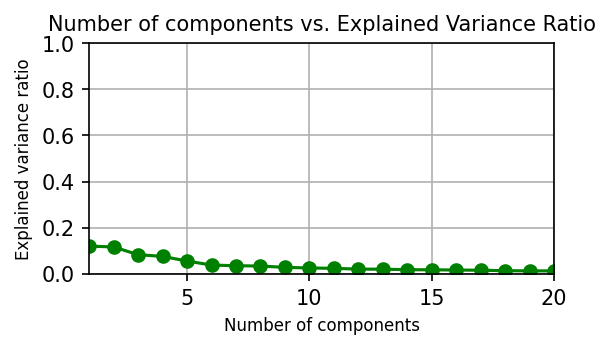

In [26]:
#plot the explained variance vs the number of components
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(components,explained_variance_ratio,marker='o', color='green')

plt.xlabel('Number of components', size=8)
plt.xlim([1,len(components)])

plt.ylabel('Explained variance ratio', size=8)
plt.ylim([0,1])

#add title 
plt.title('Number of components vs. Explained Variance Ratio', size=10)

plt.show()

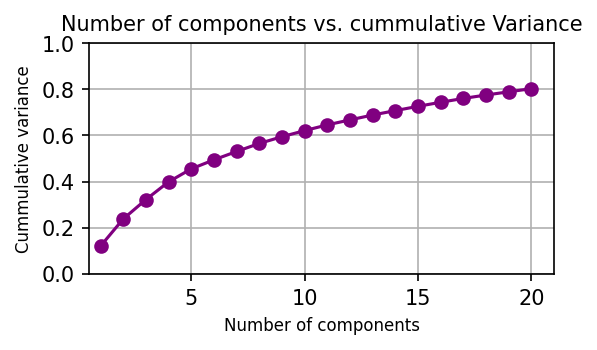

In [27]:
#plot the cummulative variance vs the number of components
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(components,cumulative_variance,marker='o', color='purple')

plt.xlabel('Number of components', size=8)
plt.xlim([0.5,len(components)+1])

plt.ylabel('Cummulative variance', size=8)
plt.ylim([0,1])

plt.title('Number of components vs. cummulative Variance', size=10)


plt.show()

## PC1 and PC2  

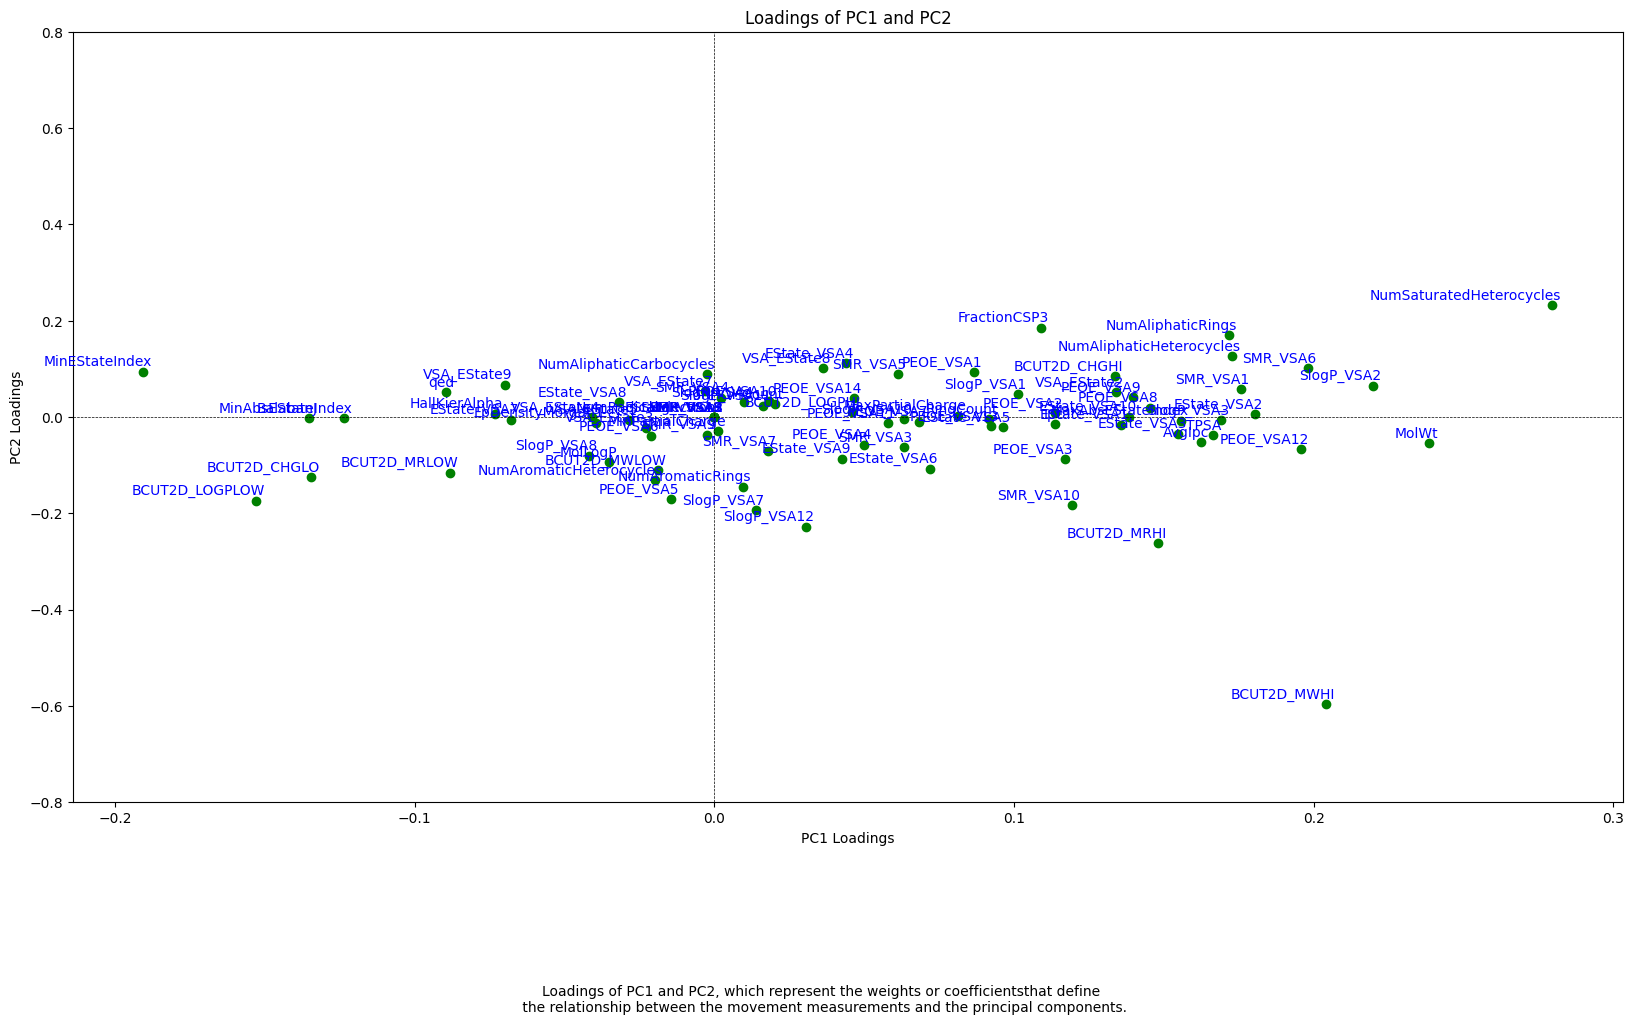

In [28]:
# Get loadings for PC1 and PC2
loadings_pc1 = pca_6.components_[0]
loadings_pc2 = pca_6.components_[1]

# Create scatter plot of loadings PC1 and PC2
plt.figure(figsize=(20,10))
plt.scatter(loadings_pc1, loadings_pc2,color='green')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)  # Horizontal zero line
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)  # Vertical zero line
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.ylim([-0.9,0.6])
plt.ylim([-0.8,0.8])
plt.title('Loadings of PC1 and PC2')

#display the variables corresponding to the points in the plot
variables = pca_df.columns
for i, variable in enumerate(variables):
    plt.annotate(variable, (loadings_pc1[i], loadings_pc2[i]), color='blue',xytext=(6, 2), textcoords='offset points', ha='right', va='bottom')


# Add figure caption
plt.figtext(0.5, -0.1, "Loadings of PC1 and PC2, which represent the weights or coefficients" 
            "that define \n the relationship between the movement measurements and the principal components.", ha='center')

plt.show()

In [29]:
variables

Index(['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed',
       'MolWt', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'HallKierAlpha', 'Ipc',
       'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13',
       'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1',
       'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6',
       'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',
       'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1',
       'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA4', 'EState_VSA5', 'E

In [30]:
#determine the most significant 20 descriptors that describe our data

list_variables = []
weights = list(range(20,0,-1))
j = 0 
for pc in range(len(components)):
    loadings_pc = pca_6.components_[pc]
    i = 0
    weight = weights[j]
    j = j+1
    for value in loadings_pc:
        weighted_value = abs(value)*weight
        if weighted_value>4 and variables[i] not in list_variables:
            list_variables.append(variables[i])
        else:
            None
        i = i+1

print(list_variables)
        


['MolWt', 'BCUT2D_MWHI', 'SlogP_VSA2', 'NumSaturatedHeterocycles', 'BCUT2D_MRHI', 'SlogP_VSA12', 'HallKierAlpha', 'NumAromaticRings', 'MinEStateIndex', 'SlogP_VSA8', 'EState_VSA1', 'EState_VSA4', 'EState_VSA7', 'SlogP_VSA11', 'EState_VSA9', 'SMR_VSA7', 'PEOE_VSA2', 'NumAliphaticCarbocycles', 'PEOE_VSA8', 'PEOE_VSA12', 'SlogP_VSA7']


In [31]:
#make a list of all chosen descriptors

df_good_variables = pca_df[list_variables].copy()
df_good_variables.insert(0, 'SMILES', df_molecules['SMILES'])
df_good_variables

,SMILES,MolWt,BCUT2D_MWHI,SlogP_VSA2,NumSaturatedHeterocycles,BCUT2D_MRHI,SlogP_VSA12,HallKierAlpha,NumAromaticRings,MinEStateIndex,SlogP_VSA8,EState_VSA1,EState_VSA4,EState_VSA7,SlogP_VSA11,EState_VSA9,SMR_VSA7,PEOE_VSA2,NumAliphaticCarbocycles,PEOE_VSA8,PEOE_VSA12,SlogP_VSA7
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,0.688495,0.084394,0.647103,0.5,0.233313,0.000000,0.184564,0.6,0.732144,0.170668,0.118778,0.302955,0.642042,0.25,0.105513,0.479709,0.277948,0.0,0.641177,0.739676,0.0
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,0.501554,0.838092,0.263603,0.0,0.715999,0.253468,0.333893,0.8,0.821655,0.335008,0.000000,0.347615,0.428028,0.00,0.098392,0.624993,0.271356,0.0,0.122345,0.245987,0.0
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,0.591847,0.841296,0.323120,0.0,0.698454,0.488615,0.473154,0.6,0.359067,0.337814,0.197051,0.344362,0.483225,0.00,0.000000,0.410909,0.263765,0.0,0.441564,0.663378,0.0
5,CC1CCCCN1S(=O)(=O)c1ccc(NC(=O)c2cccc(-n3cnnn3)...,0.607114,0.841302,0.517485,0.5,0.691891,0.000000,0.325503,0.6,0.317093,0.170668,0.197051,0.242219,0.081420,0.00,0.000000,0.481790,0.138974,0.0,0.470626,0.417391,0.0
6,COCCN(C(=O)C(F)(F)F)C(C(=O)NC1CCCCC1)c1ccco1,0.496980,0.225887,0.495042,0.0,0.240332,0.000000,0.506711,0.2,0.089430,0.000000,0.601128,0.403699,0.000000,0.00,0.203905,0.192616,0.277948,0.5,0.388869,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,CCc1c(C)nc2ncnn2c1N1CCCC(C(=O)NCc2ccc3c(c2)OCO...,0.598297,0.095477,0.456579,0.5,0.215968,0.000000,0.283557,0.6,0.819211,0.173377,0.000000,0.753789,0.295434,0.50,0.211027,0.329694,0.138974,0.0,0.609898,0.528860,0.0
995,COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1,0.244151,0.084368,0.312035,0.5,0.311446,0.000000,0.531879,0.2,0.797366,0.000000,0.000000,0.161480,0.062523,0.25,0.105513,0.193488,0.277948,0.5,0.253534,0.245987,0.0
997,NC(=O)Cn1cnc(-c2ccccc2)c1,0.112166,0.069088,0.155558,0.0,0.202220,0.000000,0.494966,0.4,0.777850,0.337814,0.000000,0.141558,0.356690,0.00,0.127717,0.341724,0.138974,0.0,0.232185,0.245987,0.0
998,Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...,0.532279,0.838092,0.357259,0.0,0.716046,0.253468,0.374161,0.6,0.766362,0.335008,0.221148,0.057430,0.162841,0.00,0.100752,0.260461,0.542711,0.0,0.517341,0.245987,0.0


## Scores


In [32]:
#calculate the scores
scores = pca_6.transform(pca_df)

#see the scores of pc1 and pc2
scores_pc1 = scores[:, 0]
scores_pc2 = scores[:, 1]


In [33]:
#add the scores to the  dataframe and create a new dataframe

Pca_mols_df = pca_df.copy()

#see the scores for all the pcs
for pc in range(len(pca_6.components_)):
    scores_pc = scores[:, pc]
    Pca_mols_df['scores PC'+str(pc+1)] = scores_pc
    
Pca_mols_df['scores PC1'] = scores_pc1
Pca_mols_df['scores PC2'] = scores_pc2


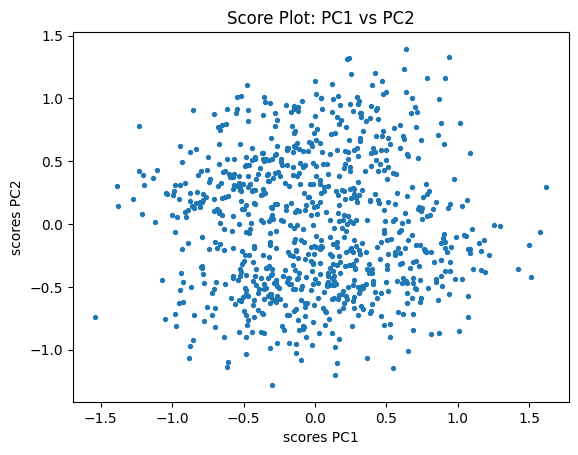

<Axes: xlabel='scores PC1', ylabel='scores PC2'>

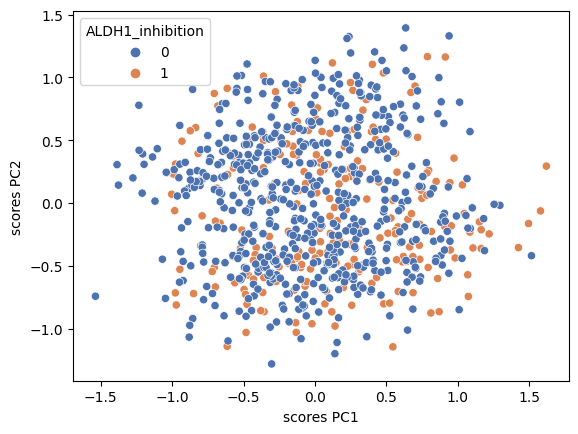

In [34]:
# Create scatter plot of scores
principal_1 = 'scores PC1'
principal_2 = 'scores PC2'
scores = pd.concat([df_molecules[['SMILES', 'ALDH1_inhibition']], Pca_mols_df[[principal_1,principal_2]]], axis=1, join = 'inner')
plt.scatter(scores_pc1, scores_pc2, s=8)
plt.xlabel(principal_1)
plt.ylabel(principal_2)
plt.title('Score Plot: PC1 vs PC2')
plt.show()
sns.scatterplot(data=scores, x=principal_1, y=principal_2, hue='ALDH1_inhibition' , palette = "deep")

# Machine Learning

### Data splitting 

In [35]:
#split the data in training and test set (80/20)
df_good_variables.insert(0,'ALDH1_inhibition', df_molecules['ALDH1_inhibition'])
input_values = df_molecules[list_variables]
output_values = df_molecules['ALDH1_inhibition']
X_train, X_test, y_train, y_test = train_test_split(input_values, output_values, test_size=0.2, random_state=42)

# K-Means

### Making a k-means model

In [36]:
df_pca

array([[ 0.71868892,  0.52315357, -0.64441991, ...,  0.00615291,
        -0.02272003,  0.12971653],
       [-0.06873021, -0.6610568 , -0.33522403, ...,  0.14967802,
        -0.03635435, -0.13031567],
       [ 0.48158005, -0.80227497,  0.03766289, ..., -0.47115172,
         0.08436536, -0.21574464],
       ...,
       [-0.95208407,  0.2020814 , -0.18505484, ..., -0.07329704,
         0.18052663,  0.00958463],
       [ 0.40673537, -0.47842826, -0.28642104, ...,  0.427329  ,
        -0.18835955, -0.26191449],
       [-0.08410594, -0.81097562, -0.49770917, ...,  0.0145516 ,
         0.06885387,  0.03444973]])

In [37]:
#Making a k-means model with 3 clusters:

kmeans_3 = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
 )     

kmeans_3.fit(df_pca)
#fitting the model

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [38]:
#The SSE(sum of the squared error) for this model
kmeans_3.inertia_


1319.3668067839467

In [39]:
#The centers of the clusters
kmeans_3.cluster_centers_

array([[ 6.45985449e-01, -2.51328052e-01,  6.60762708e-02,
        -8.64348003e-02, -2.81575784e-02, -3.45751816e-02,
        -1.12916612e-01, -3.20733943e-03, -4.15614778e-02,
         4.31263768e-02, -8.33730115e-03,  9.71975980e-03,
        -2.36235437e-02,  1.26673345e-02,  1.73902196e-02,
        -1.72622747e-02,  1.77165170e-02, -2.75819811e-03,
         1.69433430e-02,  2.58363382e-02],
       [-2.34435800e-01, -4.64602119e-01,  2.39335534e-01,
         9.85074080e-02,  5.14425473e-02,  2.56629131e-04,
         8.68653916e-02,  2.35676018e-02, -9.50871075e-03,
        -2.93415374e-02, -2.24378674e-02, -4.08958006e-02,
         1.63951242e-02, -1.55952804e-03, -2.43873887e-02,
        -2.86502107e-03, -2.07543693e-02,  1.31838963e-02,
        -1.27763100e-02, -1.70677520e-02],
       [-1.92924249e-01,  4.81826876e-01, -2.12439432e-01,
        -2.33215397e-02, -2.17601021e-02,  1.93210890e-02,
         1.40846689e-04, -1.54380701e-02,  3.04097786e-02,
        -2.86046176e-03,  2.1

In [40]:
#Amount of iterations
kmeans_3.n_iter_ 

18

In [41]:
#Array which tells us which data belongs to which cluster
kmeans_3.labels_

array([2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 2, 2, 0, 0,
       0, 1, 0, 0, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 1, 1, 0, 2, 1, 2,
       1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1,
       0, 1, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1,
       1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 2, 1,
       0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1, 1, 0, 2, 0,
       1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 0, 2, 2, 0,

### Determining the most optimal amount of clusters

In [42]:
#Making a new model try different amounts of clusters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

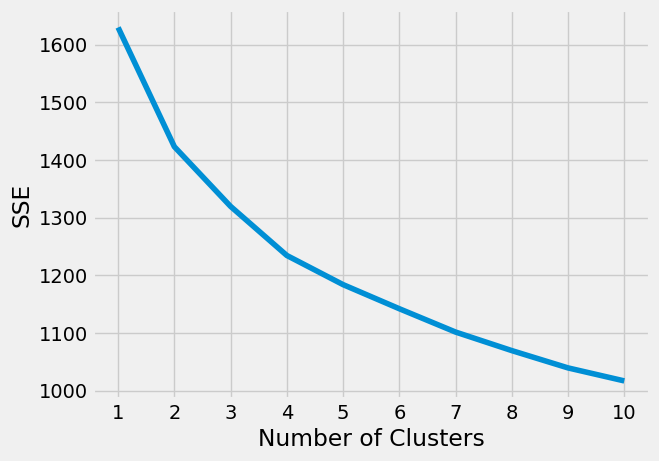

In [43]:
#plot the sse-values
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()         

In [44]:
#Using kneed to determine what the best amount of clusters is according to the graph
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

4

In [45]:
#another method to determine the best amount of clusters
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_pca)

    score =  silhouette_score(df_pca, kmeans.labels_)

    silhouette_coefficients.append(score)

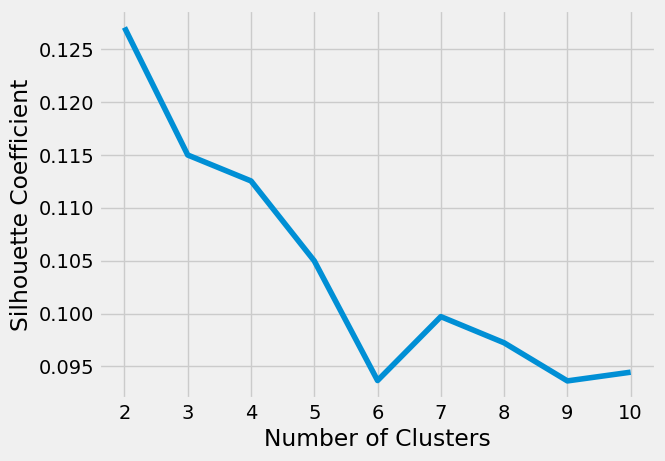

In [46]:
#Plotting the silhouette coefficients, the higher the better
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Plotting the data in clusters

C:\Users\fleur\anaconda3\envs\Advancedprogramming\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


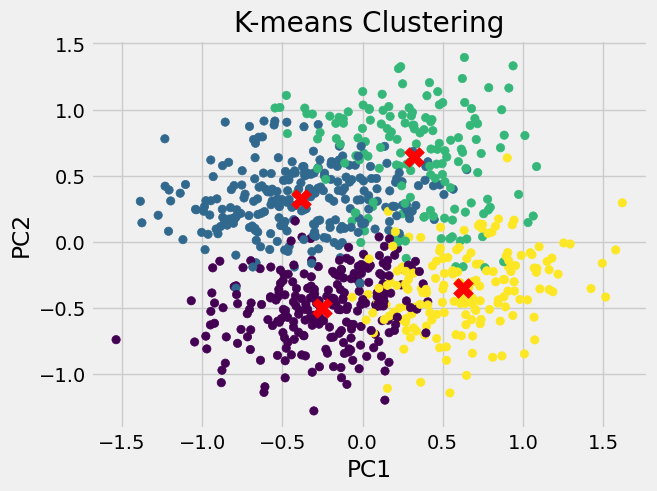

In [47]:
# Apply K-means clustering on the reduced data
k = 4  #Amount of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_pca)

 

# Get the cluster labels and cluster centers
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

 

# Create a scatter plot of the reduced data with cluster labels
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', s=200)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering')
plt.show()

In [48]:
#Silhouette coefficient score for 4 clusters
score =  silhouette_score(df_pca, kmeans.labels_)
score

0.11359820450020909

# Random forest

Since there is more 0 then 1 labelled data, we set weights to the data

In [49]:
#first check the ditribution of the data

zeros_count = df_molecules['ALDH1_inhibition'].value_counts().get(0, 0)
ones_count = df_molecules['ALDH1_inhibition'].value_counts().get(1, 0)

print("Number of zeros:", zeros_count)
print("Number of ones:", ones_count)

Number of zeros: 700
Number of ones: 300


In [50]:
# Calculate the class weights
class_weight = {0: 1, 1: 3}  


To check how many estimators to use, visualize the cross validation with different numbers of estimators

<module 'matplotlib.pyplot' from 'C:\\Users\\fleur\\anaconda3\\envs\\Advancedprogramming\\lib\\site-packages\\matplotlib\\pyplot.py'>

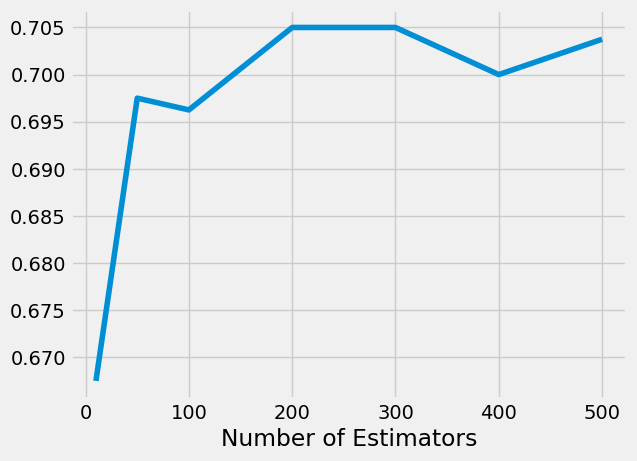

In [51]:
# Define a range of estimators
estimators = [10, 50, 100, 200, 300, 400, 500]

# Perform cross-validation and evaluate the model
cv_scores = []
for n_estimators in estimators:
    rf_classifier = RandomForestClassifier(class_weight=class_weight, n_estimators=n_estimators)
    #cv = 10 because we use K-fold cross validation, which is a good method for our dataset
    scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)
    cv_scores.append(scores.mean())

# Plot the cross-validation scores
plt.plot(estimators, cv_scores)
plt.xlabel('Number of Estimators')
plt


In [52]:
X_train

,MolWt,BCUT2D_MWHI,SlogP_VSA2,NumSaturatedHeterocycles,BCUT2D_MRHI,SlogP_VSA12,HallKierAlpha,NumAromaticRings,MinEStateIndex,SlogP_VSA8,EState_VSA1,EState_VSA4,EState_VSA7,SlogP_VSA11,EState_VSA9,SMR_VSA7,PEOE_VSA2,NumAliphaticCarbocycles,PEOE_VSA8,PEOE_VSA12,SlogP_VSA7
29,265.314,32.166451,42.112966,0.0,8.124957,11.761885,-1.69,1.0,-0.011435,0.000000,0.000000,11.712408,6.255769,11.499024,9.473726,23.762553,4.992405,0.0,0.000000,6.792942,0.0
535,310.392,19.142144,24.740797,1.0,5.439728,0.000000,-2.15,2.0,-1.483607,0.000000,5.601051,13.089513,30.331835,0.000000,0.000000,71.541427,0.000000,0.0,23.968546,0.000000,0.0
695,280.327,16.465312,17.200303,0.0,5.813127,0.000000,-2.75,3.0,0.051943,10.902925,0.000000,27.903275,54.597304,11.629500,4.736863,60.160755,0.000000,0.0,23.181818,5.879988,0.0
557,378.354,19.413183,27.671240,0.0,5.929467,0.000000,-3.10,3.0,-4.497962,11.033401,24.253812,34.525570,32.046576,0.000000,4.837589,53.088557,4.794537,0.0,5.687386,0.000000,0.0
836,261.302,32.133473,12.700122,0.0,7.097361,11.336786,-2.01,2.0,-0.112764,0.000000,0.000000,4.877147,18.370167,11.499024,9.473726,40.086130,4.794537,0.0,22.010963,6.792942,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,301.386,16.392017,5.907180,0.0,5.946773,0.000000,-2.10,2.0,-0.349898,10.969244,0.000000,41.462978,19.913841,0.000000,4.417151,39.746128,4.794537,0.0,23.560799,5.907180,0.0
270,393.509,32.233438,48.914385,1.0,7.887466,12.217873,-2.03,2.0,-3.685942,0.000000,15.840512,11.629819,35.231745,0.000000,12.217873,65.977976,0.000000,0.0,32.723782,10.023291,0.0
860,382.511,32.233445,41.917069,1.0,7.888345,11.336786,-1.71,2.0,-3.642991,0.000000,10.023291,4.877147,17.512797,0.000000,0.000000,33.777800,9.893219,0.0,17.966660,15.930471,0.0
435,420.585,32.137904,31.840120,0.0,7.099649,34.206058,-2.10,3.0,-0.735625,0.000000,11.580766,21.286781,55.796805,0.000000,0.000000,55.853879,9.589074,0.0,20.673282,5.907180,0.0


In [53]:
y_train

29     1
535    0
695    0
557    0
836    0
      ..
106    1
270    1
860    0
435    0
102    1
Name: ALDH1_inhibition, Length: 800, dtype: int64

In [54]:
# Create a Random Forest classifier with 100 trees
rf_classifier = RandomForestClassifier(class_weight=class_weight, n_estimators=400)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=400)

In [55]:
# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [56]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
y_test

Accuracy: 0.67


521    0
737    0
740    0
660    0
411    0
      ..
408    0
332    0
208    1
613    0
78     1
Name: ALDH1_inhibition, Length: 200, dtype: int64

# Test v2

In [57]:
file_name = r"tested_molecules_v2.csv"
with open(file_name, "r") as ins:
    smiles = []
    for line in ins:
        smiles.append(line.split('\n')[0])

In [58]:
#split the csv file into multiple columns
#read the dataframe
df_tested = pd.read_csv(file_name)

# #split the csv file into multiple columns
# #read the dataframe
df_tested = pd.read_csv(file_name)

# #split the dataframe
#new_columns = df_molecules['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
#df_tested = pd.concat([df_molecules, new_columns], axis=1)

# #drop the original column
#df_tested = df_molecules.drop('SMILES;ALDH1_inhibition', axis=1)

# #rename the column names 
#df_tested = df_molecules.rename(columns={0:'SMILES',1:'ALDH1_inhibition'})

df_tested

,SMILES,ALDH1_inhibition
0,[NH3+]CCSSCC[NH3+],0
1,[NH3+]CCC[NH2+]CCCC[NH2+]CCC[NH3+],0
2,[NH3+]CCCCCCCCCC[NH3+],0
3,[NH3+]CCSSCC[NH3+],0
4,ClCC[NH+](CCCl)CCCl,0
...,...,...
995,C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1,1
996,COC(=O)c1c(NC(C)=O)sc2c1CCCCC2,1
997,O=C(CCl)NC1CCCc2ccccc21,1
998,COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1,1


In [59]:
only_smiles_list = df_tested['SMILES']

smiles_tryout = only_smiles_list
mols = [Chem.MolFromSmiles(smi) for smi in smiles_tryout]
desc_list = [n[0] for n in Descriptors._descList]

calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
df_tested

,SMILES,ALDH1_inhibition
0,[NH3+]CCSSCC[NH3+],0
1,[NH3+]CCC[NH2+]CCCC[NH2+]CCC[NH3+],0
2,[NH3+]CCCCCCCCCC[NH3+],0
3,[NH3+]CCSSCC[NH3+],0
4,ClCC[NH+](CCCl)CCCl,0
...,...,...
995,C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1,1
996,COC(=O)c1c(NC(C)=O)sc2c1CCCCC2,1
997,O=C(CCl)NC1CCCc2ccccc21,1
998,COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1,1


In [60]:
rdkit_desc_data = [calc.CalcDescriptors(m) for m in mols]

rdkit_desc = []
for element in rdkit_desc_data:   
    tuple_floats = tuple(float(x) for x in element)
    rdkit_desc.append(tuple_floats)

In [61]:
for col in range(len(desc_list)):
    column = []
    for row in range(len(rdkit_desc)):
        #the row iteration is for the molecule and the col iteration for the descriptor, this makes a list which will be
        #added to the dataframe
        descriptor = rdkit_desc[row][col]
        column.append(descriptor)
    df_tested[desc_list[col]] = column
df_tested_variables = df_tested[list_variables]

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_tested_variables

C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\77735402.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tested[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\77735402.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tested[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\77735402.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

,MolWt,BCUT2D_MWHI,SlogP_VSA2,NumSaturatedHeterocycles,BCUT2D_MRHI,SlogP_VSA12,HallKierAlpha,NumAromaticRings,MinEStateIndex,SlogP_VSA8,EState_VSA1,EState_VSA4,EState_VSA7,SlogP_VSA11,EState_VSA9,SMR_VSA7,PEOE_VSA2,NumAliphaticCarbocycles,PEOE_VSA8,PEOE_VSA12,SlogP_VSA7
0,154.304,33.114600,24.595220,0.0,8.762746,21.587796,0.62,0.0,1.036517,0.000000,0.0,13.089513,21.587796,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,206.378,14.863441,39.268538,0.0,4.334156,0.000000,-0.16,0.0,1.078701,0.000000,0.0,13.089513,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,25.683286,0.000000,0.0
2,174.332,14.512585,13.089513,0.0,4.449205,0.000000,-0.08,0.0,1.112603,0.000000,0.0,13.089513,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,154.304,33.114600,24.595220,0.0,8.762746,21.587796,0.62,0.0,1.036517,0.000000,0.0,13.089513,21.587796,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,205.536,35.497842,37.274280,0.0,6.181272,34.802820,0.83,0.0,0.683642,0.000000,0.0,19.634269,0.000000,0.000000,34.802820,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,251.330,32.092047,10.824122,0.0,7.800764,12.217873,-1.49,1.0,-0.266642,0.000000,0.0,11.399071,6.923737,0.000000,12.217873,30.082689,5.425791,1.0,11.399071,0.000000,0.0
996,267.350,32.133570,18.986283,0.0,7.165150,11.336786,-1.36,1.0,-0.348935,0.000000,0.0,31.246738,0.000000,0.000000,4.736863,16.004050,4.794537,1.0,11.800884,5.907180,0.0
997,223.703,35.495663,11.787183,0.0,6.267804,11.600940,-1.02,1.0,-0.084843,0.000000,0.0,19.262465,12.132734,0.000000,11.600940,35.392371,4.794537,1.0,0.000000,5.907180,0.0
998,423.542,32.166556,56.004780,1.0,7.993595,11.761885,-2.87,3.0,0.152230,17.075242,0.0,36.386749,45.865212,5.749512,4.736863,48.791890,14.345615,0.0,36.231122,5.907180,0.0


In [62]:
y_pred = rf_classifier.predict(df_tested_variables)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [63]:
accuracy = accuracy_score(df_tested['ALDH1_inhibition'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.716


# performance matrix 

In [64]:
target_names = ['Bad inhibitor (0)', 'Good inhibitor (1)']
print(classification_report(df_tested['ALDH1_inhibition'], y_pred, target_names=target_names))

                    precision    recall  f1-score   support

 Bad inhibitor (0)       0.71      1.00      0.83       700
Good inhibitor (1)       0.94      0.06      0.11       300

          accuracy                           0.72      1000
         macro avg       0.83      0.53      0.47      1000
      weighted avg       0.78      0.72      0.61      1000



In [65]:
#Confusion matrix, Accuracy, sensitivity and specificity

cm1 = confusion_matrix(df_tested['ALDH1_inhibition'], y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity0 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity 0 : ', sensitivity0 )

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity 1 : ', sensitivity1 )

BAcc = (sensitivity0+sensitivity1)/2
print('Balanced accuracy:', BAcc)

Confusion Matrix : 
 [[699   1]
 [283  17]]
Accuracy :  0.716
Sensitivity 0 :  0.9985714285714286
Sensitivity 1 :  0.056666666666666664
Balanced accuracy: 0.5276190476190477


# Untested molecules


In [66]:
file_name = r"untested_molecules.csv"
with open(file_name, "r") as ins:
    smiles = []
    for line in ins:
        smiles.append(line.split('\n')[0])


In [67]:
#split the csv file into multiple columns
#read the dataframe
df_untested = pd.read_csv(file_name)

# #split the csv file into multiple columns
# #read the dataframe
df_untested = pd.read_csv(file_name)

df_untested

,SMILES
0,CCCCC/C(=N\NC(=O)CCC(=O)NCc1ccccc1)c1ccccc1
1,Cc1ccc(S(=O)(=O)N2CCC(C(=O)OCC(=O)N3CCc4ccccc4...
2,COc1ccc(N2C(=O)CC(Nc3ccc(F)cc3)C2=O)c([N+](=O)...
3,Cc1cc(C)cc(OCC(=O)O[NH+]=C(N)Cc2ccc([N+](=O)[O...
4,NNC(=O)C=C1CCN(c2ncc(C(F)(F)F)cc2Cl)CC1
...,...
9995,CCNC(=O)c1nc[nH]c1C(=O)NCC
9996,CCC(C)C(NC(=O)C(C)NC(=O)CNC(=O)CNC(=O)OCc1cccc...
9997,O=C(CSc1ncnc2ccccc12)Nc1cccc(S(=O)(=O)N2CCOCC2)c1
9998,Cc1cc(OCCOCC[NH+](C)CCO)cc(C)c1Cl


In [68]:
only_smiles_list = df_untested['SMILES']

smiles_tryout = only_smiles_list
mols = [Chem.MolFromSmiles(smi) for smi in smiles_tryout]
desc_list = [n[0] for n in Descriptors._descList]

calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)


In [69]:
rdkit_desc_data = [calc.CalcDescriptors(m) for m in mols]

rdkit_desc = []
for element in rdkit_desc_data:   
    tuple_floats = tuple(float(x) for x in element)
    rdkit_desc.append(tuple_floats)

In [70]:
df_untested_vars = df_untested.copy()
for col in range(len(desc_list)):
    column = []
    for row in range(len(rdkit_desc)):
        #the row iteration is for the molecule and the col iteration for the descriptor, this makes a list which will be
        #added to the dataframe
        descriptor = rdkit_desc[row][col]
        column.append(descriptor)
    df_untested[desc_list[col]] = column
df_untested_vars = df_untested[list_variables]

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_untested_vars

C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\2767703703.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_untested[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\2767703703.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_untested[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\2767703703.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\2767703703.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_untested[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\2767703703.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_untested[desc_list[col]] = column
C:\Users\fleur\AppData\Local\Temp\ipykernel_29840\2767703703.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

,MolWt,BCUT2D_MWHI,SlogP_VSA2,NumSaturatedHeterocycles,BCUT2D_MRHI,SlogP_VSA12,HallKierAlpha,NumAromaticRings,MinEStateIndex,SlogP_VSA8,EState_VSA1,EState_VSA4,EState_VSA7,SlogP_VSA11,EState_VSA9,SMR_VSA7,PEOE_VSA2,NumAliphaticCarbocycles,PEOE_VSA8,PEOE_VSA12,SlogP_VSA7
0,379.504,16.155548,17.526044,0.0,6.006437,0.000000,-2.95,2.0,-0.251126,0.000000,0.000000,42.521874,60.663671,0.000000,0.000000,71.790574,9.589074,0.0,19.386400,11.814359,0.000000
1,442.537,32.233427,50.840649,1.0,7.887355,0.000000,-2.71,2.0,-3.572690,0.000000,21.910502,23.235111,31.189205,0.000000,4.736863,59.657840,9.589074,0.0,25.321655,10.023291,0.000000
2,359.313,19.142146,29.889309,1.0,6.236926,0.000000,-3.49,2.0,-0.893827,0.000000,34.284118,10.966277,0.000000,5.749512,4.736863,58.396109,19.703393,0.0,5.687386,5.907180,0.000000
3,358.374,16.678907,23.335118,0.0,5.772305,0.000000,-3.42,2.0,-0.628881,0.000000,10.892616,16.690354,32.046576,5.749512,15.308119,69.269242,20.685574,0.0,12.132734,0.000000,0.000000
4,334.729,35.495692,23.980671,1.0,6.325608,11.600940,-1.80,1.0,-4.469682,0.000000,11.739750,17.836315,5.425791,0.000000,17.443610,34.498420,10.220329,0.0,25.362376,0.000000,5.022633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,210.237,16.154385,34.871829,0.0,6.041917,0.000000,-1.85,1.0,-0.347219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.715176,9.589074,0.0,13.089513,0.000000,0.000000
9996,464.519,16.547882,62.067077,0.0,5.919847,0.000000,-3.63,1.0,-0.947497,0.000000,48.412523,5.563451,25.122838,0.000000,9.473726,35.895287,14.383612,0.0,0.000000,17.721539,0.000000
9997,444.538,32.233453,60.654280,1.0,7.996720,11.761885,-2.53,3.0,-3.620036,10.902925,10.023291,15.928885,24.265468,0.000000,4.736863,54.858257,4.794537,0.0,24.163123,15.930471,0.000000
9998,302.822,35.495692,51.671240,0.0,6.316629,11.600940,-0.81,1.0,0.212513,0.000000,0.000000,34.988561,33.027881,5.749512,26.181193,28.282270,0.000000,0.0,5.022633,0.000000,5.022633


In [71]:
#doing the prediction on all the possible inhibitors
pred_input=rf_classifier.predict(df_untested_vars)
prob_inhibitors=rf_classifier.predict_proba(df_untested_vars)
prob_inhibitors

array([[0.8075, 0.1925],
       [0.5625, 0.4375],
       [0.84  , 0.16  ],
       ...,
       [0.3825, 0.6175],
       [0.645 , 0.355 ],
       [0.795 , 0.205 ]])

In [72]:
#putting them in a dataframe
df_prob_inhibitors=pd.DataFrame(prob_inhibitors,columns=['inhibitor=False','inhibitor=True'])
df_prob_inhibitors['inhibitor(0 or 1)']=pred_input
df_prob_inhibitors.insert(0,'SMILES',df_untested['SMILES'])

In [73]:
df_sorted_inhibitors=df_prob_inhibitors.sort_values(by=['inhibitor=True'],ascending=False)
df_sorted_inhibitors

,SMILES,inhibitor=False,inhibitor=True,inhibitor(0 or 1)
4451,CCn1c(=S)[nH]c2sc3c(c2c1=O)CCCCC3,0.1775,0.8225,1
4004,CCN1C(=O)C(CC(=O)Nc2ccc(OC)cc2)N(CCc2ccc(OC)cc...,0.1800,0.8200,1
1221,CCOc1cc(/C=C2/SC(=S)N(CC3CCCO3)C2=O)ccc1O,0.1825,0.8175,1
7163,CCc1cc2c(=O)n(CCC(C)C)c(=S)[nH]c2s1,0.1975,0.8025,1
4298,CCc1cc(C(=O)c2ccc(C)cc2)c(NC(=O)CCl)s1,0.1975,0.8025,1
...,...,...,...,...
7313,Cc1cccc(OCc2nc(C)cc(O)n2)c1,0.9600,0.0400,0
8677,CCS(=O)(=O)N1CCC(C(=O)NCc2ccc(F)cc2)CC1,0.9650,0.0350,0
9679,O=C([O-])c1cccc(N2CCCCS2(=O)=O)c1,0.9700,0.0300,0
753,COc1ccc(-n2c(=O)c(C)nc3cnc(Nc4ccccc4)nc32)cc1,0.9700,0.0300,0


In [76]:
list_with_100_inhibitors=df_sorted_inhibitors['SMILES'].values[0:100]
for x in list_with_100_inhibitors:
    print(x)

CCn1c(=S)[nH]c2sc3c(c2c1=O)CCCCC3
CCN1C(=O)C(CC(=O)Nc2ccc(OC)cc2)N(CCc2ccc(OC)cc2)C1=S
CCOc1cc(/C=C2/SC(=S)N(CC3CCCO3)C2=O)ccc1O
CCc1cc2c(=O)n(CCC(C)C)c(=S)[nH]c2s1
CCc1cc(C(=O)c2ccc(C)cc2)c(NC(=O)CCl)s1
COc1ccc(CCN2C(=S)N(C)C(=O)C2CC(=O)Nc2ccc(F)cc2)cc1
O=C(CCc1ccc(Oc2cc([N+](=O)[O-])cc([N+](=O)[O-])c2)cc1)N1CCCCC1
COc1cccc(C2NC(S)=[NH+]C3=C2CCc2ccccc23)c1
O=S(=O)(c1ccccc1F)N1CCN(C(=S)NCc2ccccc2)CC1
COc1cc(NC(=O)C[NH+]2CCN(S(=O)(=O)c3ccc(C(C)C)cc3)CC2)cc(OC)c1
CCOc1ccc(S(=O)(=O)Nc2ccc(S(=O)(=O)N3CCCCC3)cc2)cc1
O=C1c2ccccc2C(=O)N1CCCCN(C(=O)c1cccc([N+](=O)[O-])c1)c1ccc(Cl)cc1
COCCNC(=O)CSc1nc2cc(OC)c(OC)cc2c(=O)n1Cc1ccco1
CC(C)c1ccc(N2C(=O)NC(=O)/C(=C\c3cnc(-c4ccccc4)nc3)C2=O)cc1
CCOc1ccccc1N(CC(=O)N1CCOCC1)S(=O)(=O)c1ccc(SC)cc1
CCCN1C(=O)/C(=C/c2cc(C)n(C)c2C)SC1=[NH+]c1ccc(OC)cc1
COc1ccc(NC(=O)C[NH+]2CCc3ccccc3C2)cc1S(=O)(=O)N1CCOCC1
COc1ccc(NC(=O)/C(=C/c2ccc(OC(C)=O)c(OC)c2)NC(C)=O)cc1
Nc1nc(NCc2ccco2)nc(N2CCCCC2)c1[N+](=O)[O-]
COc1ccc(S(=O)(=O)Nc2ccc(S(=O)(=O)N3CCCC3)cc2)cc1
COc1ccc